### Basic Imports

In [1]:
%pip install -U git+https://github.com/sustainability-lab/ASTRA

  Cloning https://github.com/sustainability-lab/ASTRA to /tmp/pip-req-build-ty0kk7ec
  Running command git clone --filter=blob:none -q https://github.com/sustainability-lab/ASTRA /tmp/pip-req-build-ty0kk7ec
  Resolved https://github.com/sustainability-lab/ASTRA to commit 99a7e7f36f94e2bd51bd9b37e91e1349fa799df3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


In [18]:
import astra
astra.__version__

'0.0.3.dev5+g99a7e7f'

In [22]:
def train_fn(model, inputs, outputs, loss_fn, optimizer, epochs=100, batch_size=32, verbose=False):
    model.train()
    losses = []
    for epoch in range(epochs):
        for i in range(0, len(inputs), batch_size):
            x = inputs[i:i+batch_size]
            y = outputs[i:i+batch_size]
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        losses.append(loss.item())
        if verbose:
            print(f"Epoch {epoch+1}/{epochs}, loss={loss.item():.4f}")
    return losses

In [21]:
import sys
sys.version

'3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:20:46) \n[GCC 9.4.0]'

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import seaborn as sns
import pandas as pd

dist =torch.distributions
import torchsummary

sns.reset_defaults()
sns.set_context(context="talk", font_scale=1)
%matplotlib inline
%config InlineBackend.figure_format='retina'

from functools import partial

In [2]:
n_epochs = 100

In [23]:
from astra.torch.data import load_mnist


In [24]:
# Create a sine activation class similar to ReLU
class Sine(nn.Module):
    def __init__(self):
        super().__init__()
        self.w = nn.Parameter(torch.tensor(1.0))
        self.b = nn.Parameter(torch.tensor(0.0))
        
    def forward(self, x):
        return torch.sin(self.w * x + self.b)

In [25]:
# Autoencoder class with 1 hidden layer and hidden dim = z
class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size=128, z=2, act = nn.ReLU()):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            act, # Using Sine activation
            nn.Linear(hidden_size, z)
        )
        self.decoder = nn.Sequential(
            nn.Linear(z, hidden_size),
            act,
            nn.Linear(hidden_size, input_size),
            nn.Sigmoid()  # Sigmoid activation for reconstruction
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [27]:
dataset = load_mnist()
dataset


MNIST Dataset
length of dataset: 70000
shape of images: torch.Size([28, 28])
len of classes: 10
classes: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
dtype of images: torch.float32
dtype of labels: torch.int64

In [28]:
# Train over 1000 images
train_idx = torch.arange(1000)

X = dataset.data[train_idx].to(device)
# Add a channel dimension
X = X.unsqueeze(1).float()

X = X/255.0

model = Autoencoder(input_size=784, hidden_size=128, z=32,act=Sine()).to(device)

In [29]:
X.shape

torch.Size([1000, 1, 28, 28])

In [30]:
model(X.view(-1, 28*28*1)).shape

torch.Size([1000, 784])

In [31]:
# Get reconstruction
def get_reconstruction(model, X, model_type='MLP'):
    with torch.no_grad():
        model.eval()
        if model_type == 'MLP':
           X = X.view(-1, 28*28*1)
        X_hat = model(X)
        if model_type == 'MLP':
           X_hat = X_hat.view(-1, 1, 28, 28)
        return X_hat

In [32]:
r = get_reconstruction(model, X)
r.max(), r.min(), r.shape

(tensor(0.5834, device='cuda:0'),
 tensor(0.4045, device='cuda:0'),
 torch.Size([1000, 1, 28, 28]))

In [33]:
nn.MSELoss()(r, X)

tensor(0.2326, device='cuda:0')

In [34]:
# Plot original and reconstructed images
def plot_reconstructions(model, X, n=5, model_type='MLP'):
    X = X[:n]
    X_hat = get_reconstruction(model, X, model_type=model_type)
    # Use torchvision.utils.make_grid to make a grid of images
    X_grid = torch.cat([X, X_hat], dim=0)
    X_grid = torchvision.utils.make_grid(X_grid, nrow=n)
    plt.imshow(X_grid.cpu().permute(1, 2, 0).numpy())
    plt.axis('off')

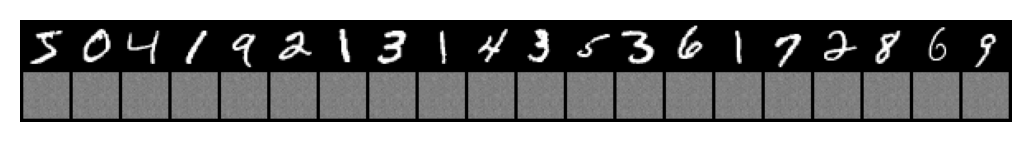

In [35]:
plot_reconstructions(model, X, 20)

In [37]:
setattr(model, 'device', device)
l = train_fn(model=model, inputs=X.view(-1, 28*28),
                                     outputs=X.view(-1, 28*28),
                                     loss_fn=nn.MSELoss(),
                                     optimizer=torch.optim.Adam(model.parameters(), lr=1e-3),
                                     epochs=1000,
                                        batch_size=500,
                                        verbose=False)


In [38]:
r = get_reconstruction(model, X)

In [39]:
r.min(), r.max()

(tensor(2.3002e-08, device='cuda:0'), tensor(1.0000, device='cuda:0'))

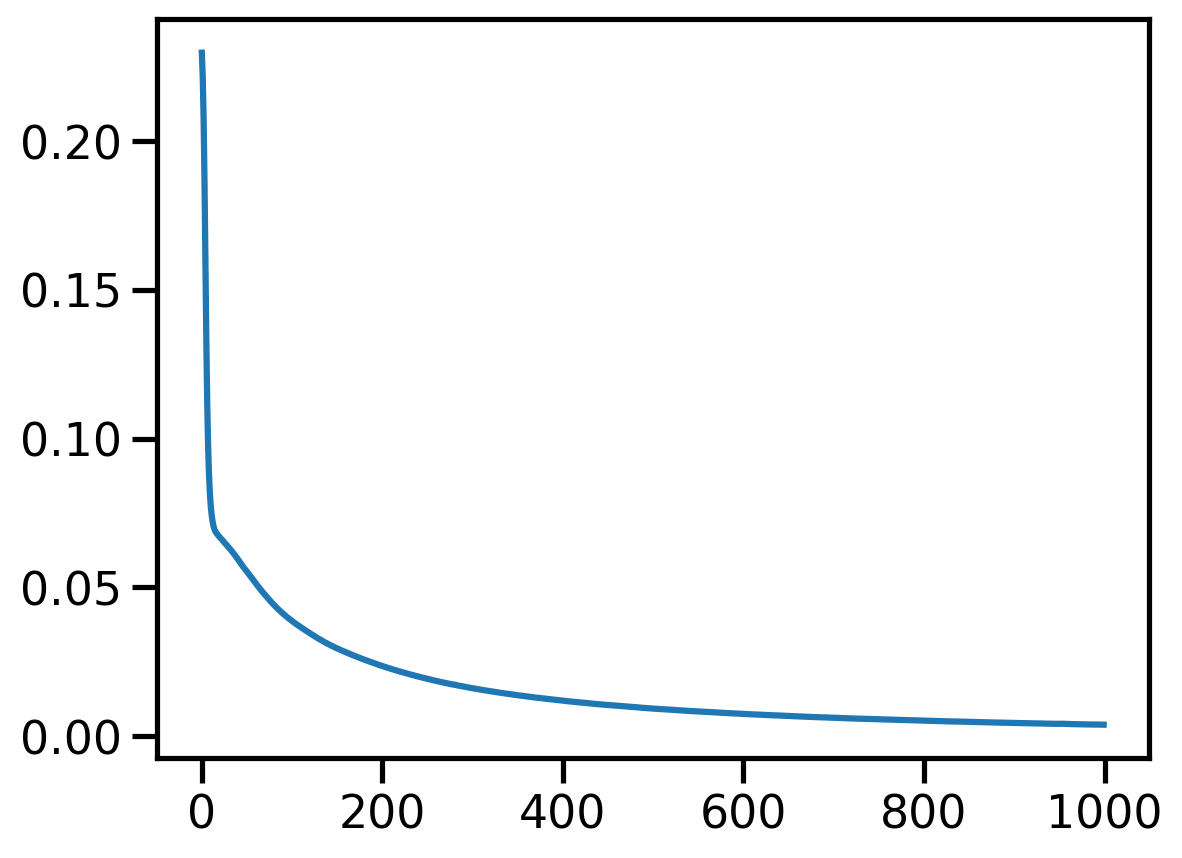

In [40]:
_ = plt.plot(l)

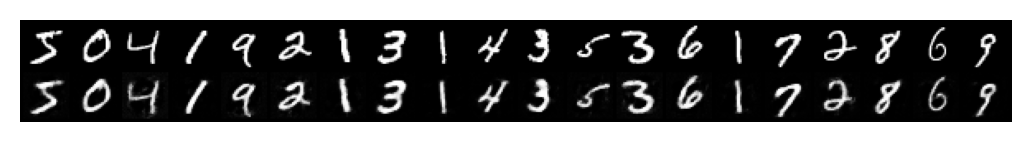

In [41]:
plot_reconstructions(model, X, 20)

In [42]:
import torch.nn as nn

class ConvAutoEncoderMNIST(nn.Module):
    def __init__(self, latent_dim=2, act=nn.ReLU()):
        super(ConvAutoEncoderMNIST, self).__init__()
        self.latent_dim = latent_dim

        # Encoder layers with further reduced filters
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1),  # 1X28X28 -> 4X28X28
            act,
            nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, stride=2, padding=1),  # 4X28X28 -> 8X14X14
            act,
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1),  # 8X14X14 -> 16X7X7
            act,
            nn.Flatten(),  # 16X7X7 -> 784
            nn.Linear(784, self.latent_dim)
        )

        # Decoder layers with further reduced filters
        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, 784),  # 784 -> 16X7X7
            nn.Unflatten(1, (16, 7, 7)),  # 784 -> 16X7X7
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, stride=2, padding=1, output_padding=1),  # 16X7X7 -> 8X14X14
            act,
            nn.ConvTranspose2d(in_channels=8, out_channels=4, kernel_size=3, stride=2, padding=1, output_padding=1),  # 8X14X14 -> 4X28X28
            act,
            nn.ConvTranspose2d(in_channels=4, out_channels=1, kernel_size=3, padding=1),  # 4X28X28 -> 1X28X28
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [43]:
m = ConvAutoEncoderMNIST(latent_dim=32, act=Sine()).to(device)
torchsummary.summary(m, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 28, 28]              40
              Sine-2            [-1, 4, 28, 28]               0
              Sine-3            [-1, 4, 28, 28]               0
            Conv2d-4            [-1, 8, 14, 14]             296
              Sine-5            [-1, 8, 14, 14]               0
              Sine-6            [-1, 8, 14, 14]               0
            Conv2d-7             [-1, 16, 7, 7]           1,168
              Sine-8             [-1, 16, 7, 7]               0
              Sine-9             [-1, 16, 7, 7]               0
          Flatten-10                  [-1, 784]               0
           Linear-11                   [-1, 32]          25,120
           Linear-12                  [-1, 784]          25,872
        Unflatten-13             [-1, 16, 7, 7]               0
  ConvTranspose2d-14            [-1, 8,

In [44]:
m(X).shape

torch.Size([1000, 1, 28, 28])

In [45]:
latent_dim_ranges = [2, 4, 8, 16, 32, 64, 128]

In [46]:
caes = {}
for latent_dim in latent_dim_ranges[:]:
    caes[latent_dim] = ConvAutoEncoderMNIST(latent_dim=latent_dim, act=Sine()).to(device)
    setattr(caes[latent_dim], 'device', device)

In [47]:
torchsummary.summary(caes[2], (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 28, 28]              40
              Sine-2            [-1, 4, 28, 28]               0
              Sine-3            [-1, 4, 28, 28]               0
            Conv2d-4            [-1, 8, 14, 14]             296
              Sine-5            [-1, 8, 14, 14]               0
              Sine-6            [-1, 8, 14, 14]               0
            Conv2d-7             [-1, 16, 7, 7]           1,168
              Sine-8             [-1, 16, 7, 7]               0
              Sine-9             [-1, 16, 7, 7]               0
          Flatten-10                  [-1, 784]               0
           Linear-11                    [-1, 2]           1,570
           Linear-12                  [-1, 784]           2,352
        Unflatten-13             [-1, 16, 7, 7]               0
  ConvTranspose2d-14            [-1, 8,

In [48]:
torchsummary.summary(caes[128], (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 28, 28]              40
              Sine-2            [-1, 4, 28, 28]               0
              Sine-3            [-1, 4, 28, 28]               0
            Conv2d-4            [-1, 8, 14, 14]             296
              Sine-5            [-1, 8, 14, 14]               0
              Sine-6            [-1, 8, 14, 14]               0
            Conv2d-7             [-1, 16, 7, 7]           1,168
              Sine-8             [-1, 16, 7, 7]               0
              Sine-9             [-1, 16, 7, 7]               0
          Flatten-10                  [-1, 784]               0
           Linear-11                  [-1, 128]         100,480
           Linear-12                  [-1, 784]         101,136
        Unflatten-13             [-1, 16, 7, 7]               0
  ConvTranspose2d-14            [-1, 8,

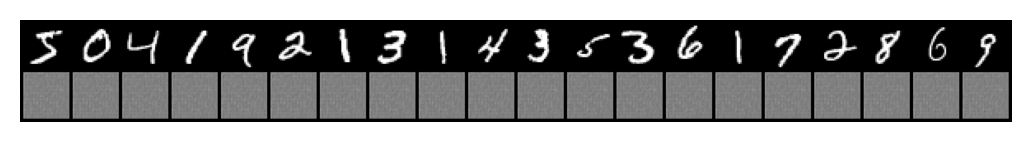

In [49]:
plot_reconstructions(caes[2], X, 20, model_type='CNN')

In [51]:
loss = {}
for latent_dim in latent_dim_ranges[:]:
    print(f"Training for latent_dim = {latent_dim}")
    loss[latent_dim] = train_fn(model=caes[latent_dim],
                                                        inputs=X,
                                                        outputs=X,
                                                        loss_fn=nn.MSELoss(),
                                                        optimizer=torch.optim.Adam(caes[latent_dim].parameters(), lr=1e-3),
                                                        epochs=1000,
                                                        batch_size=500,
                                                        verbose=False)


Training for latent_dim = 2
Training for latent_dim = 4
Training for latent_dim = 8
Training for latent_dim = 16
Training for latent_dim = 32
Training for latent_dim = 64
Training for latent_dim = 128


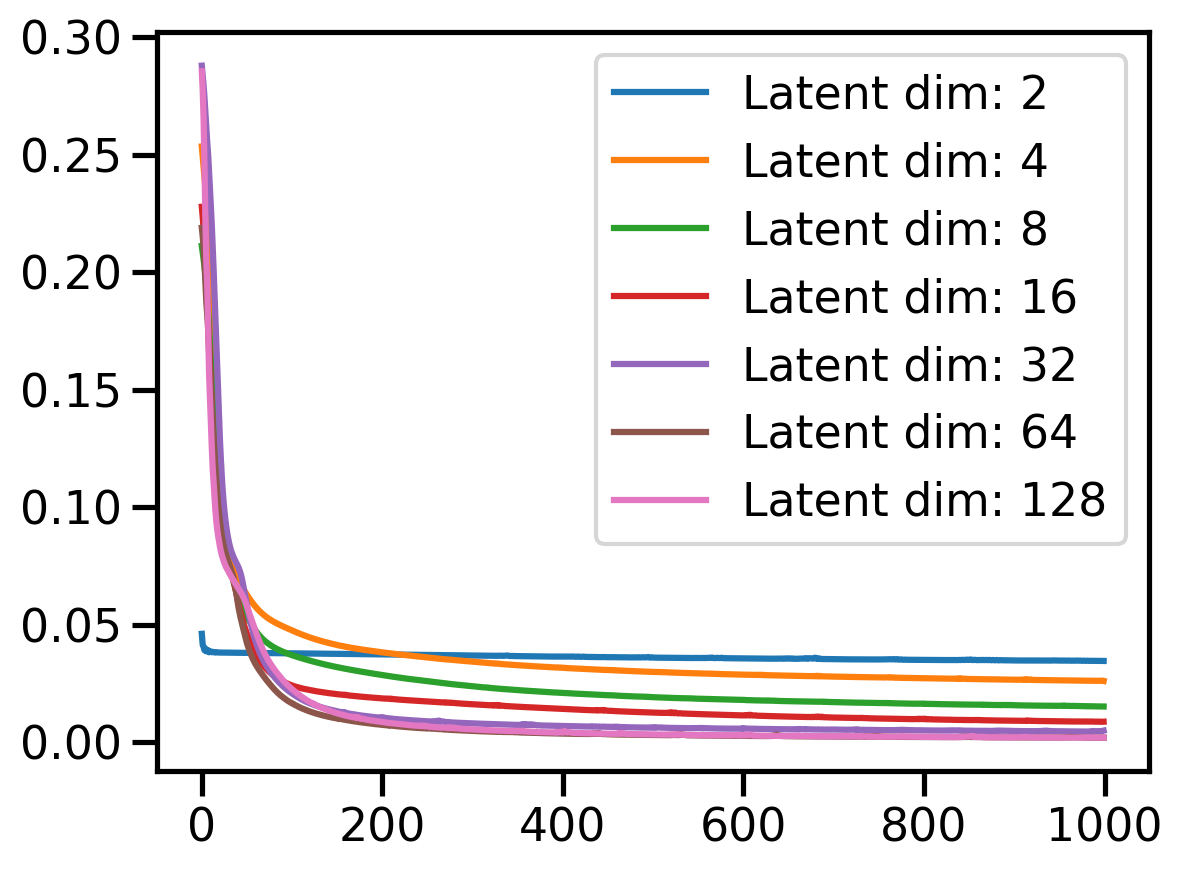

In [52]:
for latent_dim in latent_dim_ranges[:]:
    plt.plot(loss[latent_dim], label=f'Latent dim: {latent_dim}')
plt.legend()

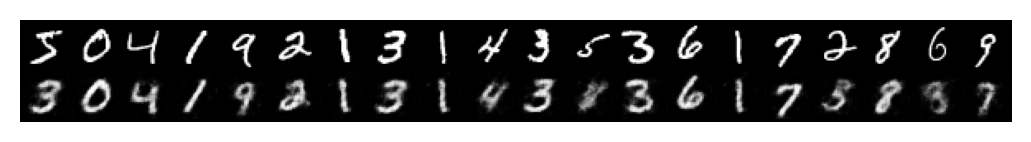

In [53]:
# Plot reconstructions
plot_reconstructions(caes[2], X, 20, model_type='CNN')

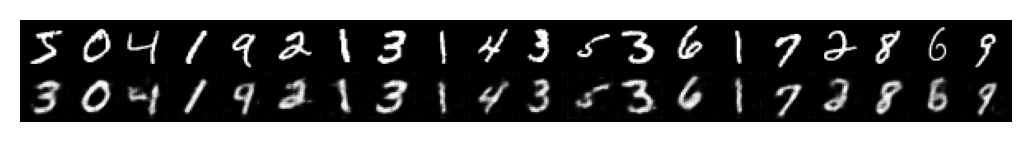

In [54]:
plot_reconstructions(caes[4], X, 20, 'CNN')

/tmp/ipykernel_806108/3276167442.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_grid = torchvision.utils.make_grid(torch.tensor(X_grid), nrow=n)


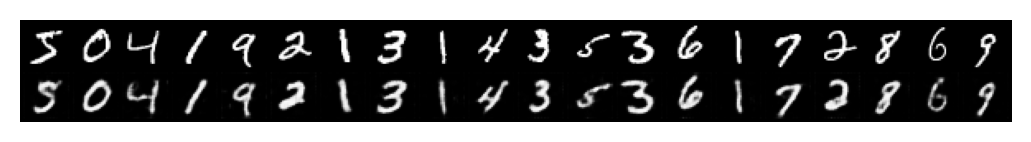

In [47]:
plot_reconstructions(caes[8], X, 20, 'CNN')

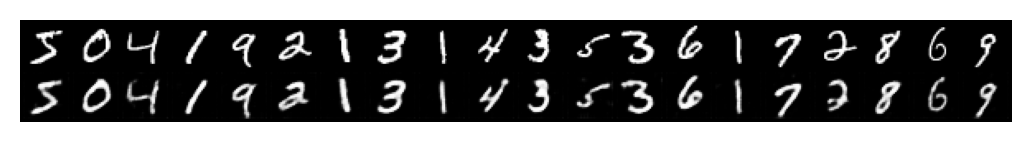

In [55]:
plot_reconstructions(caes[16], X, 20, 'CNN')

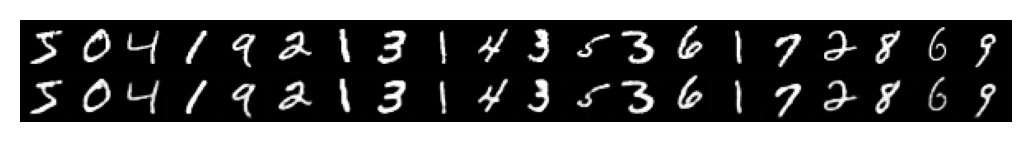

In [56]:
plot_reconstructions(caes[128], X, 20, 'CNN')

In [57]:
# Give a random input to the model and get the output
def get_random_output(model, n=5, latent_dim=2):
    with torch.no_grad():
        model.eval()
        z = torch.randn(n, latent_dim).to(device)
        X_hat = model.decoder(z)
        return X_hat

# Plot random outputs
def plot_random_outputs(model, n=5, latent_dim=2):
    X_hat = get_random_output(model, n, latent_dim)
    X_grid = torchvision.utils.make_grid(torch.tensor(X_hat), nrow=n)
    plt.imshow(X_grid.cpu().permute(1, 2, 0).numpy())
    plt.axis('off')

/tmp/ipykernel_1306109/4035786813.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_grid = torchvision.utils.make_grid(torch.tensor(X_hat), nrow=n)


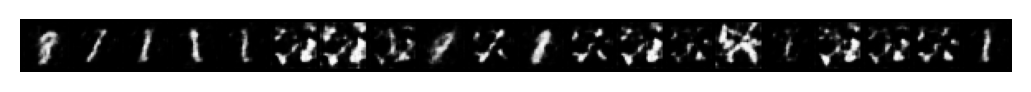

In [58]:
plot_random_outputs(caes[2], n=20)

/tmp/ipykernel_1306109/4035786813.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_grid = torchvision.utils.make_grid(torch.tensor(X_hat), nrow=n)


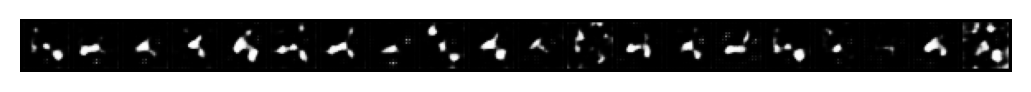

In [59]:
plot_random_outputs(caes[8], n=20, latent_dim=8)

In [63]:
# Interpolate between two points in latent space
def interpolate(model, z1, z2, n=5):
    with torch.no_grad():
        model.eval()
        z = torch.zeros(n, z1.shape[1]).to(device)
        for i in range(n):
            z[i] = z1 + (z2 - z1) * (i / (n - 1))
        X_hat = model.decoder(z)
        return X_hat

# Plot interpolation
def plot_interpolation(model, img1, img2, n=5):
    z1 = model.encoder(X[img1].unsqueeze(0))
    z2 = model.encoder(X[img2].unsqueeze(0))
    X_hat = interpolate(model, z1, z2, n)
    X_grid = torchvision.utils.make_grid(X_hat, nrow=n)
    plt.imshow(X_grid.cpu().permute(1, 2, 0).numpy())
    plt.axis('off')

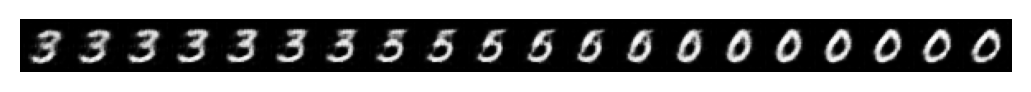

In [64]:
plot_interpolation(caes[2], 0, 1, 20)

In [66]:
# Interactive widget to plot interpolation
from ipywidgets import interact, IntSlider

def plot_interpolation_widget(img1, img2, latent_dim=2, n=20):
    plot_interpolation(caes[latent_dim], img1, img2, n)

interact(plot_interpolation_widget, img1=IntSlider(0, 0, 1000), 
         img2=IntSlider(1, 0, 1000), 
         latent_dim=latent_dim_ranges,
         n=IntSlider(20, 5, 50))

interactive(children=(IntSlider(value=0, description='img1', max=1000), IntSlider(value=1, description='img2',…

<function __main__.plot_interpolation_widget(img1, img2, latent_dim=2, n=20)>

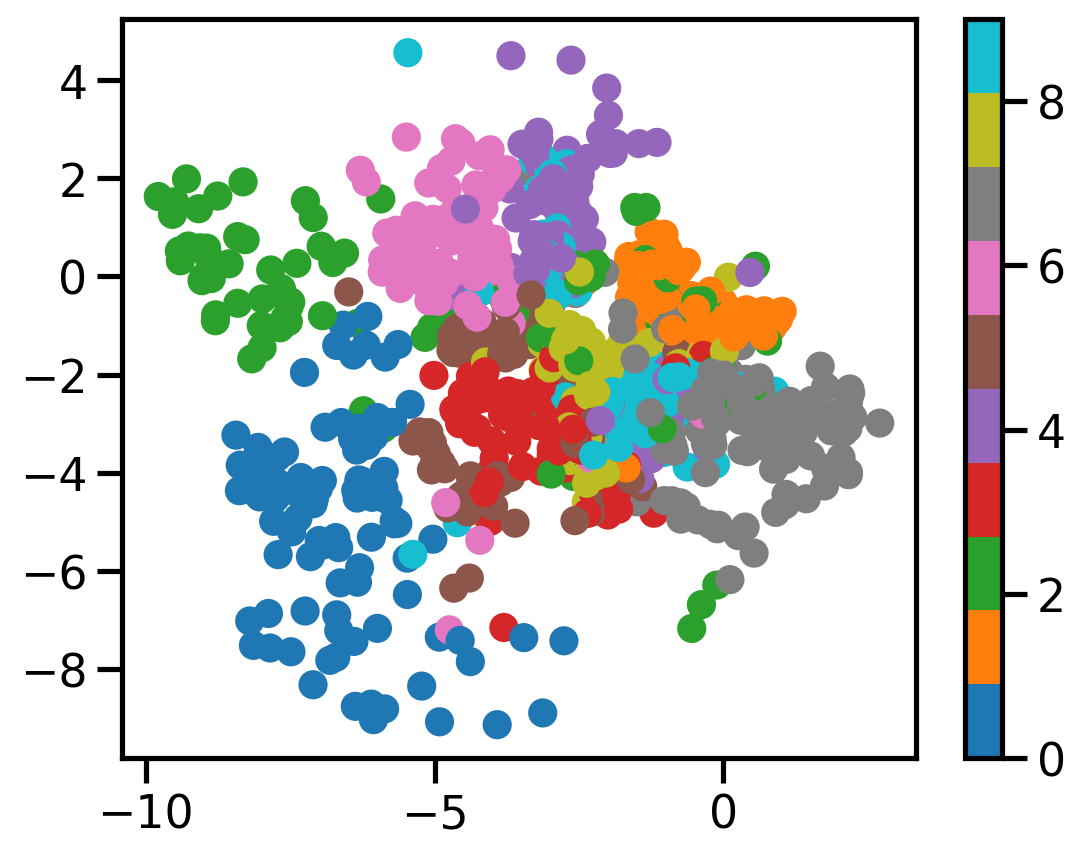

In [67]:
# plot scatter plot on 2d space for latent dim = 2 for all images
def plot_scatter(model, X, y, n=1000, latent_dim=2):
    with torch.no_grad():
        model.eval()
        z = model.encoder(X[:n].view(-1, 1, 28, 28)).cpu().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y[:n], cmap='tab10')
        plt.colorbar()

plot_scatter(caes[2], X, dataset.targets)

In [68]:
def plot_latent_space_2d(model, x_min=-2.0, x_max=2.0, y_min=-2.0, y_max=2.0, n=20):
    
    
    xx, yy = torch.meshgrid(torch.linspace(x_min, x_max, n), torch.linspace(y_min, y_max, n))
    z_grid = torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1)], dim=1)
    z_grid = z_grid.to(device)
    
    # Get the output from the decoder
    X_hat = model.decoder(z_grid)
    X_hat = X_hat.view(n, n, 28, 28)
    X_hat = X_hat.cpu().detach().numpy()
    
    # Plot the output
    plt.figure(figsize=(8, 8))
    import numpy as np
    plt.imshow(np.block(list(map(list, X_hat))), cmap='gray')
    plt.axis('off')
    

In [69]:
with torch.no_grad():
    zs = caes[2].encoder(X.view(-1, 1, 28, 28)).cpu().numpy()

# Find the min and max of the latent space
x_min = zs[:, 0].min() - 0.5
x_max = zs[:, 0].max() + 0.5

y_min = zs[:, 1].min() - 0.5
y_max = zs[:, 1].max() + 0.5


/home/nipun.batra/miniforge3/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


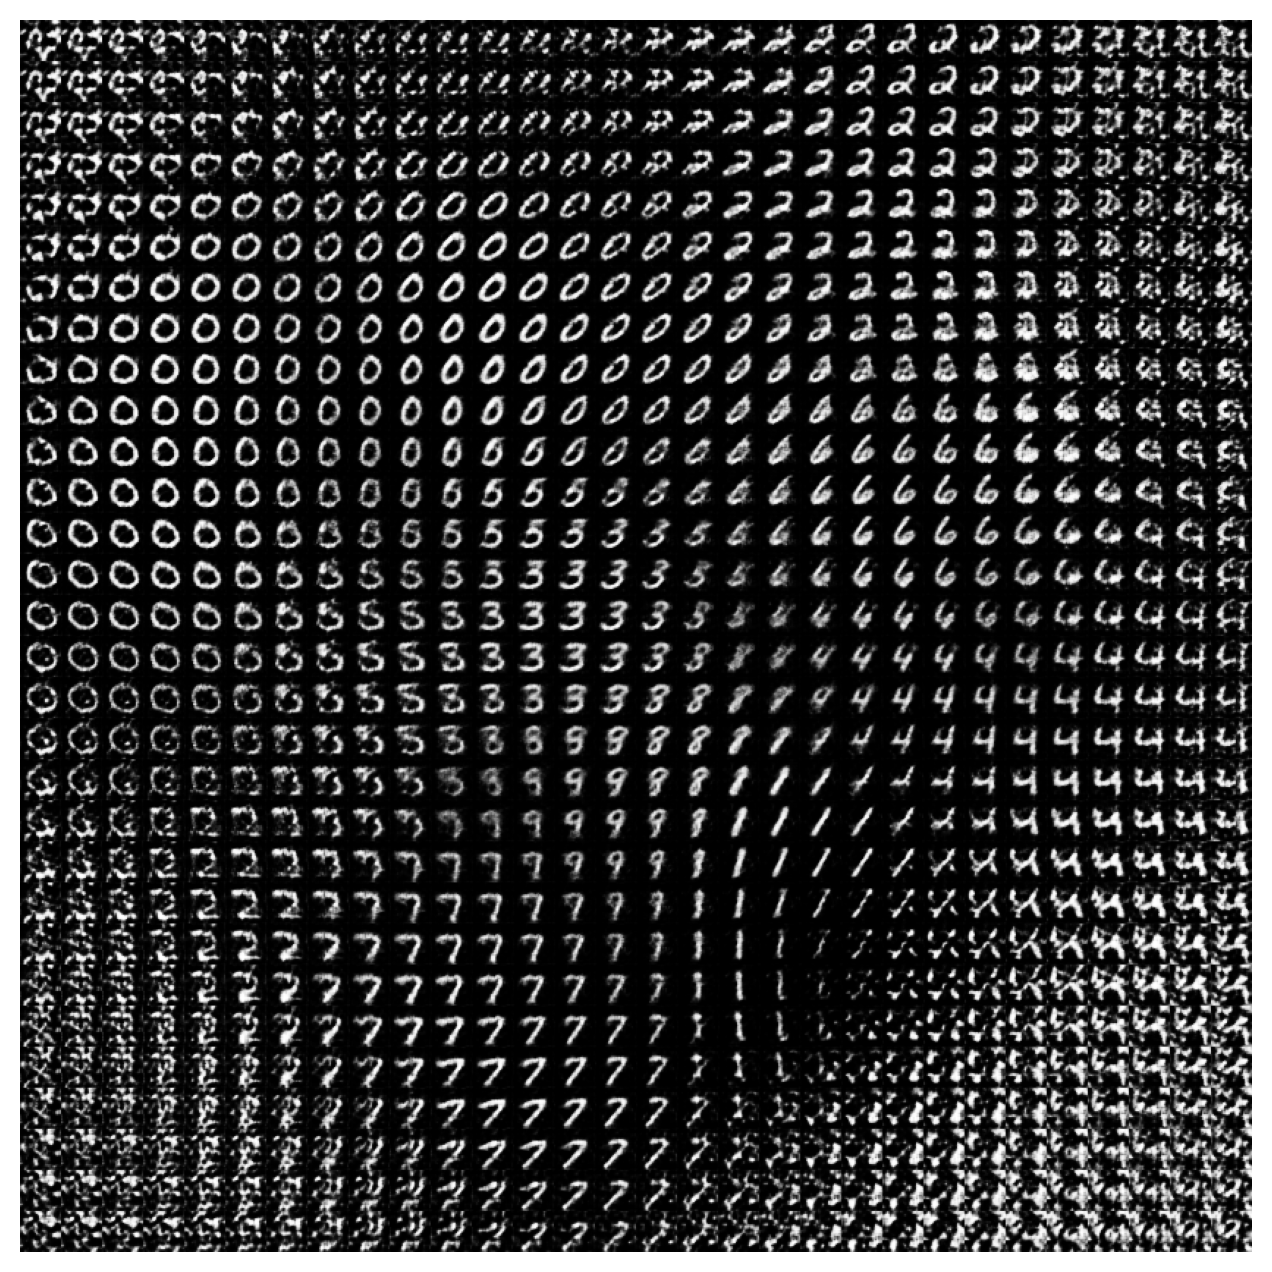

In [70]:
plot_latent_space_2d(caes[2], x_min, x_max, y_min, y_max, n=30)